In [2]:
%run tools.ipynb
import scipy.linalg

In [24]:
# generate ensemble memebers
nx = 22
ne = 20
var_l = 0.5 #00e-18# e-16 # terrestrial flux variance, (kg/m2/s)^2
#var_o = 1e-18 # ocean flux variance


In [21]:
# background covariance matrix structure
#P = np.zeros((nx,nx))
P = np.diag(np.repeat(var_l,nx))
#del_X_f = np.diag(np.repeat(prior_err,22))
P[1,1] = 0.75 # Amazon basin
P[5,5] = 0.2 # Central North America
P[6,6] = 1. # Eastern North America
P[7,7] = 0.2 # Alaska 
P[8,8] = 0.1 # Greenland
P[11,11] = 1. # Western Africa
P[12,12] = 1. # Eastern -
P[13,13] = 1. # Southern
P[15,15] = 1. # Southest Asia
P[19,19] = 1. # North Asia
P[20,20] = 0.1 # North Asia
P[21,21] = 1. # Ocean

#P[-1,-1] = var_o

L = scipy.linalg.cholesky(P, lower=True) # Cholesky decomposition
U = scipy.linalg.cholesky(P, lower=False)
uncertainty = np.diag(U)

finished creating masks for giorgi


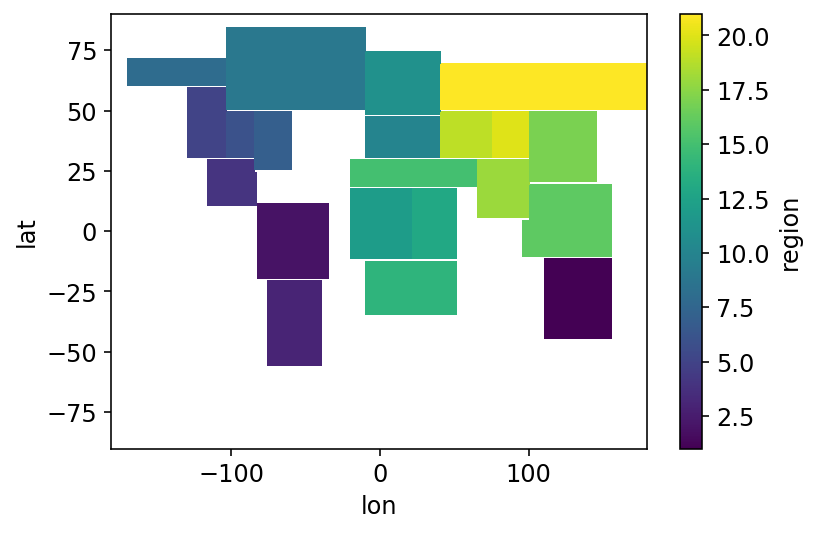

In [3]:
fname = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/NEE.Liang.2016.nc'
ds = xr.open_dataset(fname)
data = ds['CO2'].copy()

# create masks for this resolution
dr = data[0,:,:]
# create masks for input file
mask = create_masks(input_file=dr, 
                    input_file_type='dataarray', 
                    var_name='', 
                    mask_type='giorgi', 
                    output_format='xarray', 
                    output_path='/geos/u73/msadiq/GEOS-Chem/MASKS/nc/giorgi/', 
                    figure_flag = False, 
                    figure_path='/home/msadiq/Desktop/co2/data/emission/MASKS/figures/')
mask.plot()

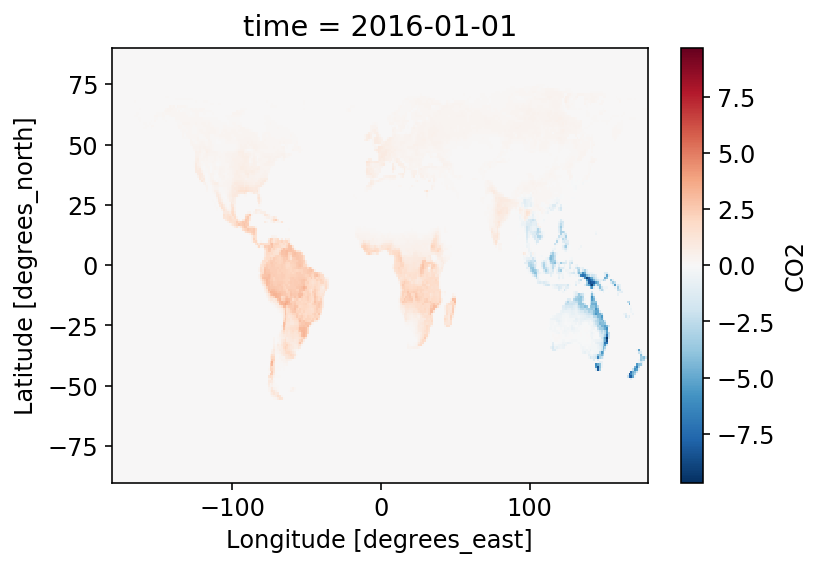

In [13]:
tmp = data[0,:,:].copy()
tmp = tmp*3600*24*365
tmp.plot()

In [12]:
np.random.normal(loc=0.0, scale=np.sqrt(1), size=nx)

array([ 0.02048377, -0.21330841,  0.04905564,  1.1339165 , -1.55595248,
       -0.54063923, -0.76321308, -0.004992  , -0.28505909, -1.09116687,
       -0.33654558, -1.52240364,  0.43907372, -1.64763664,  2.37982965,
        1.00646714,  0.3106482 , -1.03581734,  0.88613367, -1.03218284,
       -0.39546555,  1.34811882])

In [22]:
%%time
# make scaling maps for each month
scale_map = ds['CO2'][0,:,:].copy()
scale_map[:,:] = 0. # scale map, [lag_window, lat, lon]

for ilat in range(len(scale_map.lat)):
    for ilon in range(len(scale_map.lon)):
        if np.isnan(mask[ilat,ilon].values): scale_map[ilat,ilon] = uncertainty[21] # last one, ocean
        else: 
            mask_nm = int(mask[ilat,ilon].values)
            scale_map[ilat,ilon] = uncertainty[mask_nm-1] # mask number from 1 to 21


CPU times: user 44.1 s, sys: 113 ms, total: 44.2 s
Wall time: 44.2 s


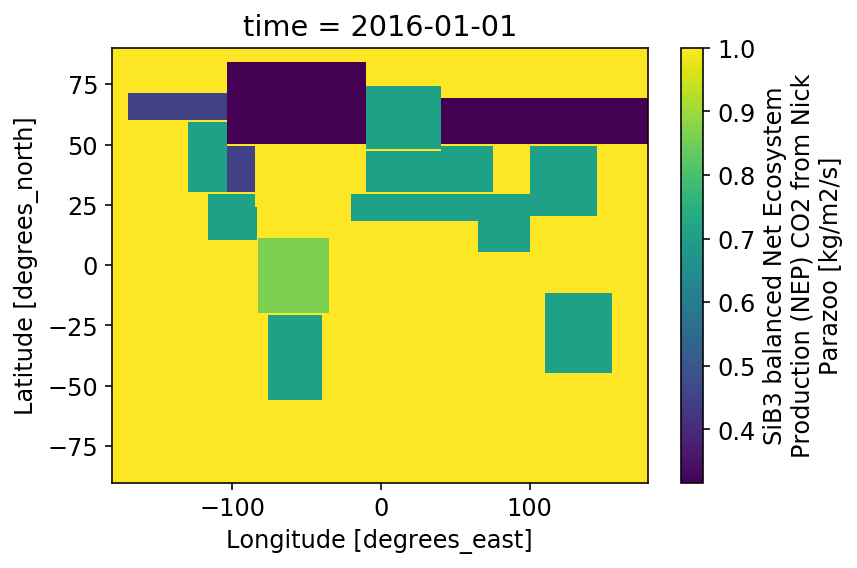

In [23]:
scale_ensemble = ds['CO2'][0:ne,:,:].copy()
scale_ensemble[:,:,:] = 0.
